In [33]:
import scanpy as sc
import numpy as np

import anndata2ri

# Activate the anndata2ri conversion between SingleCellExperiment and AnnData
anndata2ri.activate()

#Loading the rpy2 extension enables cell magic to be used
#This runs R code in jupyter notebook cells
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


/scratch/tmp.56906491.tcotet/ipykernel_22865/2749039039.py:7: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [34]:
%%R
library(Matrix)
library(Seurat)

counts <- readMM("./data/counts.mtx.gz")
meta <- read.table("./data/meta.tsv.gz")
features <- read.table("./data/features.tsv.gz")[,1]
dimnames(counts) <- list(features, rownames(meta))
seurat <- CreateSeuratObject(counts = counts, meta.data = meta)


In [35]:
%%R -o scanpy_obj
#convert the Seurat object to a SingleCellExperiment object
scanpy_obj <- as.SingleCellExperiment(seurat)

scanpy_obj

class: SingleCellExperiment 
dim: 75978 22484 
metadata(0):
assays(1): counts
rownames(75978): RP11-34P13.3 FAM138A ... MT-TT MT-TP
rowData names(0):
colnames(22484): GLI3_WT3_45d_AAACCTGGTCGCCATG
  GLI3_WT3_45d_AAACCTGTCCATGAGT ... GLI3_KO_D1_45d_CTGATCCGTCACACGC
  GLI3_KO_D1_45d_TGCGCAGAGTATGACA
colData names(6): orig.ident nCount_RNA ... organoid ident
reducedDimNames(0):
mainExpName: RNA
altExpNames(0):


In addition: Warning messages:
1: Layer 'data' is empty 
2: Layer 'scale.data' is empty 


Normalizing layer: counts
Performing log-normalization
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Finding variable features for layer counts
Calculating gene variances
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating feature variances of standardized and clipped values
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Regressing out G2M.Score, S.Score
  |======================================================================| 100%
Centering and scaling data matrix
  |======================================================================| 100%
PC_ 1 
Positive:  STMN2, MLLT11, RTN1, TMSB10, STMN1, GAP43, DCX, INA, TUBA1A, CD24 
	   NSG1, RAB3A, SOX

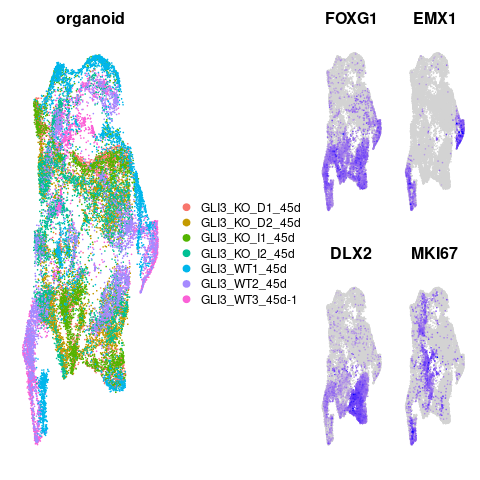

In [36]:
%%R
library(tidyverse)

seurat <- NormalizeData(seurat) %>% 
          FindVariableFeatures(nfeatures = 3000) %>% 
          CellCycleScoring(s.features = cc.genes.updated.2019$s.genes,
                           g2m.features = cc.genes.updated.2019$g2m.genes) 

VariableFeatures(seurat) <- setdiff(VariableFeatures(seurat), c(unlist(cc.genes.updated.2019), grep("^MT-", rownames(seurat), value=T)))

seurat <- ScaleData(seurat, vars.to.regress = c("G2M.Score","S.Score")) %>% 
          RunPCA(npcs = 20) %>%
          RunUMAP(dims = 1:20)

plot1 <- UMAPPlot(seurat, group.by="organoid") & NoAxes()
plot2 <- FeaturePlot(seurat, c("FOXG1","EMX1","DLX2","MKI67"), order=T) & NoAxes() & NoLegend() 
plot1 | plot2


## **CSS integration**

Start to do clustering for each sample...
  Done clustering of sample GLI3_KO_D1_45d.
  Done clustering of sample GLI3_KO_D2_45d.
  Done clustering of sample GLI3_KO_I1_45d.
  Done clustering of sample GLI3_KO_I2_45d.
  Done clustering of sample GLI3_WT1_45d.
  Done clustering of sample GLI3_WT2_45d.
  Done clustering of sample GLI3_WT3_45d-1.
Finished clustering.
Calculating average profiles of clusters...
Calculating standardized similarities to clusters...
Doing z-transformation...
Done. Returning results...
00:25:01 UMAP embedding parameters a = 0.9922 b = 1.112
Found more than one class "dist" in cache; using the first, from namespace 'spam'
Also defined by 'BiocGenerics'
00:25:01 Read 22484 rows and found 95 numeric columns
00:25:01 Using Annoy for neighbor search, n_neighbors = 30
Found more than one class "dist" in cache; using the first, from namespace 'spam'
Also defined by 'BiocGenerics'
00:25:01 Building Annoy index with metric = cosine, n_trees = 50
0%   10   20   30   40 

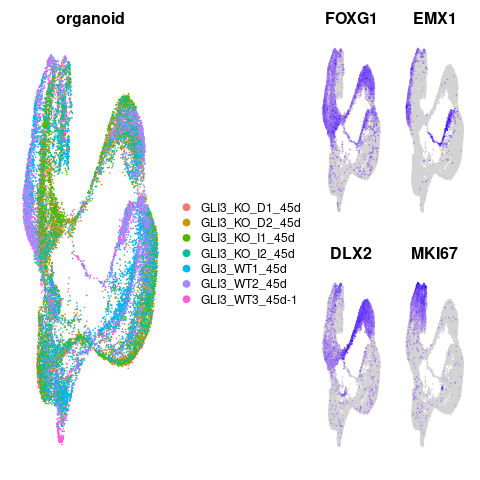

In [37]:
%%R

library(simspec)

seurat <- cluster_sim_spectrum(seurat, label_tag = "organoid", cluster_resolution = 1) 
seurat <- RunUMAP(seurat, reduction = "css", dims = 1:ncol(Embeddings(seurat,"css")), reduction.name = "umap_css", reduction.key = "UMAPCSS_")
plot1 <- DimPlot(seurat, reduction = "umap_css", group.by="GLI3_status") & NoAxes()
plot1 <- DimPlot(seurat, reduction = "umap_css", group.by="organoid") & NoAxes()
plot2 <- FeaturePlot(seurat, c("FOXG1","EMX1","DLX2","MKI67"), reduction = "umap_css", order=T) & NoAxes() & NoLegend()
plot1 | plot2

## **Harmony integration**

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 22484
Number of edges: 813649

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8842
Number of communities: 20
Elapsed time: 3 seconds


Computing nearest neighbor graph
Computing SNN
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|


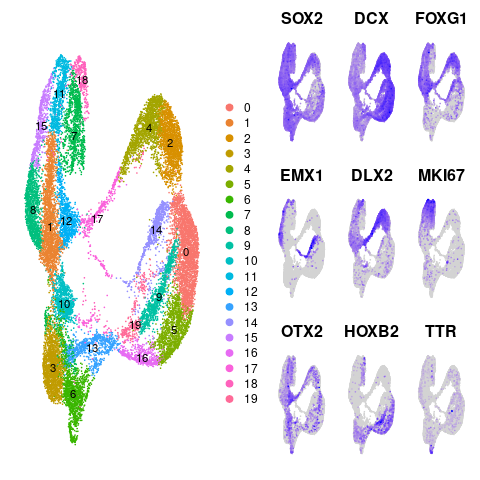

In [38]:
%%R

seurat <- FindNeighbors(seurat, reduction = "css", dims = 1:ncol(Embeddings(seurat,"css"))) %>%
          FindClusters(resolution = 0.9)

plot1 <- DimPlot(seurat, reduction = "umap_css", label = T) & NoAxes()
plot2 <- FeaturePlot(seurat, c("SOX2","DCX","FOXG1","EMX1","DLX2","MKI67","OTX2","HOXB2","TTR"),
                     reduction = "umap_css", order=T) & NoAxes() & NoLegend()
plot1 | plot2

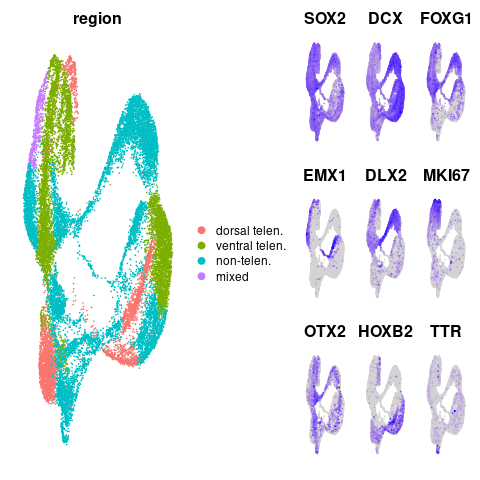

In [39]:
%%R

seurat@meta.data$region <- factor(setNames(c("ventral telen.",
                                   "ventral telen.",
                                   "non-telen.",
                                   "dorsal telen.",
                                   "non-telen.",
                                   "non-telen.",
                                   "non-telen.",
                                   "ventral telen.",
                                   "non-telen.",
                                   "dorsal telen.",
                                   "non-telen.",
                                   "ventral telen.",
                                   "non-telen.",
                                   "non-telen.",
                                   "non-telen.",
                                   "mixed",
                                   "dorsal telen.",
                                   "non-telen.",
                                   "dorsal telen.",
                                   "non-telen.",
                                   "dorsal telen."),
                                 levels(seurat@active.ident))[seurat@active.ident],
                        levels=c("dorsal telen.","ventral telen.","non-telen.","mixed"))
plot1 <- DimPlot(seurat, reduction = "umap_css", group.by = "region") & NoAxes()
plot2 <- FeaturePlot(seurat, c("SOX2","DCX","FOXG1","EMX1","DLX2","MKI67","OTX2","HOXB2","TTR"), reduction = "umap_css", order=T) & NoAxes() & NoLegend()
plot1 | plot2

## **Custom annotation**

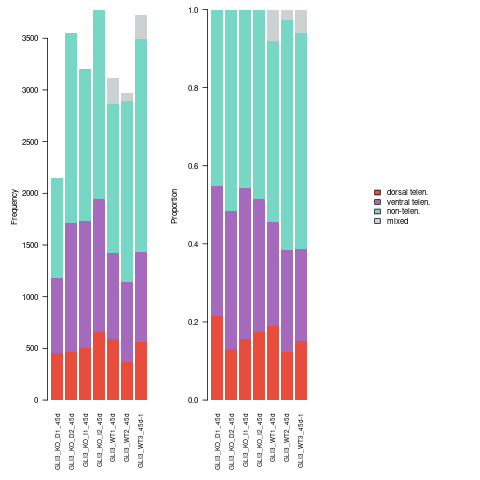

In [40]:
%%R

freq <- table(seurat$region, seurat$organoid) 
prop <- apply(freq,2,function(x) x/sum(x))

layout(matrix(1:3,nrow=1)); par(mar=c(8,5,1,1))

barplot(freq, col=c("#E74C3C","#A569BD","#76D7C4","#CCD1D1"),
        border=NA, las=2, ylab="Frequency", cex.names = 0.8) 
barplot(prop, col=c("#E74C3C","#A569BD","#76D7C4","#CCD1D1"),
        border=NA, las=2, ylab="Proportion", cex.names = 0.8) 
plot.new()
legend("left", fill=c("#E74C3C","#A569BD","#76D7C4","#CCD1D1"), legend=rownames(freq), bty="n")


In [41]:
%%R

freq_fisher <- function(conditions, have_identity){
    freq <- table(factor(have_identity, levels=c(TRUE,FALSE)), conditions)
    test <- fisher.test(freq)
    res <- setNames(c(test$estimate, test$p.value), c("oddsratio","pval_fisher")) 
    return(res)
}

region_enrichment <- data.frame(region = levels(seurat$region), # loop and test every region
    t(sapply(levels(seurat$region), function(region)
        freq_fisher(conditions = factor(seurat$GLI3_status, levels=c("KO","WT")), 
                    have_identity = seurat$region == region)
    )),
    row.names=NULL)
region_enrichment$padj_fisher <- p.adjust(region_enrichment$pval_fisher)


In [42]:
%%R
region_enrichment

          region   oddsratio   pval_fisher   padj_fisher
1  dorsal telen. 1.067449178  7.859136e-02  7.859136e-02
2 ventral telen. 1.627759644  2.514612e-61  7.543837e-61
3     non-telen. 0.803664040  4.998409e-16  9.996817e-16
4          mixed 0.002651073 1.514372e-199 6.057489e-199


In [43]:
%%R

freq_glm_aov <- function(samples, conditions, have_identity){
    sample_conditions <- unique(data.frame(sample = samples, condition = conditions)) 
    sample_conditions <- setNames(sample_conditions$condition, sample_conditions$sample)

    freq <- table(samples, factor(have_identity, levels=c(TRUE,FALSE)))
    m <- glm(freq ~ sample_conditions[rownames(freq)], family = "binomial") 
    aov <- anova(m, test = "Chisq")
    res <- setNames(c(coef(m)[2], aov$Pr[2]), c("coef_glm","pval_aov"))
    return(res)
}

region_enrichment <- data.frame(region_enrichment, # loop and test every region
    t(sapply(levels(seurat$region), function(region){ 
        freq_glm_aov(samples = seurat$organoid,
                     conditions = factor(seurat$GLI3_status, levels=c("WT","KO")),
                     seurat$region == region)
    })),
    row.names=NULL)
region_enrichment$padj_aov <- p.adjust(region_enrichment$pval_aov)


In [44]:
%%R
region_enrichment

          region   oddsratio   pval_fisher   padj_fisher    coef_glm
1  dorsal telen. 1.067449178  7.859136e-02  7.859136e-02  0.06525198
2 ventral telen. 1.627759644  2.514612e-61  7.543837e-61  0.48724071
3     non-telen. 0.803664040  4.998409e-16  9.996817e-16 -0.21859139
4          mixed 0.002651073 1.514372e-199 6.057489e-199 -5.93851427
       pval_aov      padj_aov
1  7.554810e-02  7.554810e-02
2  2.408391e-61  7.225174e-61
3  4.674732e-16  9.349465e-16
4 1.445001e-200 5.780005e-200


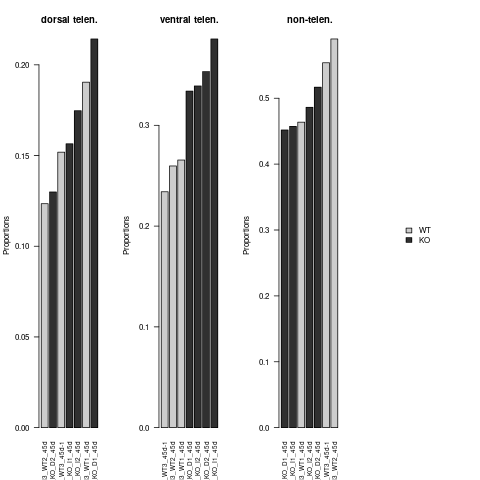

In [45]:
%%R

org_status <- unique(data.frame(organoid=seurat$organoid,
                                GLI3_status=factor(seurat$GLI3_status, levels=c("WT","KO")))) 
org_status <- setNames(org_status$GLI3_status, org_status$organoid)

layout(matrix(1:4,nrow=1))
for(region in c("dorsal telen.","ventral telen.","non-telen.")){
    props <- setNames(sapply(sort(unique(seurat$organoid)), function(organoid) 
                             mean(seurat$region[seurat$organoid == organoid] == region)),
                        sort(unique(seurat$organoid))) 
    
    barplot(props[order(props)],
            col = ifelse(org_status[names(props)[order(props)]] == "WT", "#cdcdcd", "#303030"), 
            ylab = "Proportions", main = region, las = 2, cex.names = 0.8)
}

plot.new()
legend("left", fill = c("#cdcdcd","#303030"), legend = c("WT","KO"), bty="n")


In [46]:
%%R

region_enrichment_drop1 <- data.frame( # loop and test every region
    do.call(rbind, lapply(levels(seurat$region), function(region){
        data.frame(region = region,
                   dropped = sort(unique(seurat$organoid)),

# loop and excl one sample each 
                   t(sapply(sort(unique(seurat$organoid)), function(org){
                     idx_cells <- which(seurat$organoid != org)
                     freq_fisher(conditions = factor(seurat$GLI3_status, levels=c("KO","WT")), 
                                 have_identity = seurat$region == region)
                   }))
        )
    })),
    row.names=NULL)

region_enrichment_drop1$padj_fisher <- p.adjust(region_enrichment_drop1$pval_fisher)


In [47]:
%%R
region_enrichment_drop1

           region        dropped   oddsratio   pval_fisher   padj_fisher
1   dorsal telen. GLI3_KO_D1_45d 1.067449178  7.859136e-02  5.501395e-01
2   dorsal telen. GLI3_KO_D2_45d 1.067449178  7.859136e-02  5.501395e-01
3   dorsal telen. GLI3_KO_I1_45d 1.067449178  7.859136e-02  5.501395e-01
4   dorsal telen. GLI3_KO_I2_45d 1.067449178  7.859136e-02  5.501395e-01
5   dorsal telen.   GLI3_WT1_45d 1.067449178  7.859136e-02  5.501395e-01
6   dorsal telen.   GLI3_WT2_45d 1.067449178  7.859136e-02  5.501395e-01
7   dorsal telen. GLI3_WT3_45d-1 1.067449178  7.859136e-02  5.501395e-01
8  ventral telen. GLI3_KO_D1_45d 1.627759644  2.514612e-61  5.280686e-60
9  ventral telen. GLI3_KO_D2_45d 1.627759644  2.514612e-61  5.280686e-60
10 ventral telen. GLI3_KO_I1_45d 1.627759644  2.514612e-61  5.280686e-60
11 ventral telen. GLI3_KO_I2_45d 1.627759644  2.514612e-61  5.280686e-60
12 ventral telen.   GLI3_WT1_45d 1.627759644  2.514612e-61  5.280686e-60
13 ventral telen.   GLI3_WT2_45d 1.627759644  2.514

In [48]:
%%R
label_permut <- function(samples, conditions, num_permut = 100){
     sample_conditions <- unique(data.frame(sample = samples, condition = conditions)) 
     sample_conditions <- setNames(sample_conditions$condition, sample_conditions$sample)
    
     num_samples_per_conditions <- table(sample_conditions)
     max_num_permut <- Reduce("*", sapply(2:length(num_samples_per_conditions), function(i)
                                     choose(n = sum(num_samples_per_conditions[(i-1):length(num_samples_per_conditions)]),
                                            k = num_samples_per_conditions[i])
                                   ))
                                                                               
    num_permut <- min(c(num_permut, max_num_permut)) # generate permutations of sample-condition pairs

    if (num_permut / max_num_permut < 0.2){ # random label shuffling 
        permut_sample_conditions <- lapply(1:num_permut, function(i)
            setNames(sample(sample_conditions),names(sample_conditions)))
    }else{ # exact label permutations
        permuts <- utils::combn(1:length(sample_conditions), num_samples_per_conditions[1]) 
        for(i in 2:length(num_samples_per_conditions)){
            permuts <- do.call(cbind, lapply(1:ncol(permuts), function(j){
            permuts_istep <- utils::combn(setdiff(1:length(sample_conditions), permuts[,j]),
                                          num_samples_per_conditions[i]) 
            permuts_after <- apply(permuts_istep, 2, function(x) c(permuts[,j], x))
            }))
        }

        conds <- rep(sort(unique(sample_conditions)), num_samples_per_conditions) 
        permut_sample_conditions <- lapply(sample(ncol(permuts))[1:num_permut], function(i)
            setNames(conds, names(sample_conditions)[permuts[,i]])[names(sample_conditions)]
        )
      }

    return(setNames(data.frame(as.data.frame(permut_sample_conditions),
                                   row.names=names(sample_conditions)), NULL))
}


In [49]:
%%R
permut_sample_conditions <- label_permut(seurat$organoid,
                                         factor(seurat$GLI3_status, levels=c("WT","KO")))


In [50]:
%%R
permut_sample_conditions 

                                                                             
GLI3_WT3_45d-1 KO WT KO KO KO KO WT KO KO KO KO KO WT WT WT WT KO WT KO WT KO
GLI3_KO_D1_45d WT KO KO KO KO WT KO WT WT WT WT KO WT KO WT KO WT KO WT WT WT
GLI3_KO_D2_45d WT KO WT WT WT WT WT KO KO KO WT WT WT KO KO KO KO KO KO KO WT
GLI3_KO_I1_45d WT KO WT WT WT KO KO KO WT WT KO KO KO WT WT KO KO WT WT KO KO
GLI3_KO_I2_45d KO KO KO WT KO KO WT WT WT KO WT KO KO WT KO WT KO KO KO KO KO
GLI3_WT1_45d   KO WT WT KO KO WT KO WT KO KO KO WT KO KO KO WT WT KO WT WT KO
GLI3_WT2_45d   KO WT KO KO WT KO KO KO KO WT KO WT KO KO KO KO WT WT KO KO WT
                                                        
GLI3_WT3_45d-1 KO WT KO WT KO KO KO KO WT WT WT WT KO WT
GLI3_KO_D1_45d KO WT KO KO KO WT KO KO KO KO KO KO KO WT
GLI3_KO_D2_45d WT KO KO KO KO KO KO WT WT KO WT WT KO KO
GLI3_KO_I1_45d KO KO WT WT WT KO WT KO WT KO KO KO KO KO
GLI3_KO_I2_45d WT KO WT KO WT WT KO WT KO WT KO KO WT WT
GLI3_WT1_45d   WT KO KO WT WT KO W

## **Using rMATS**

## **Using Milo**


## **Using this: https://www.biorxiv.org/content/10.1101/2022.03.23.485329v1**

## **Differential expression analysis**

Finding variable features for layer counts
Calculating gene variances
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating feature variances of standardized and clipped values
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|


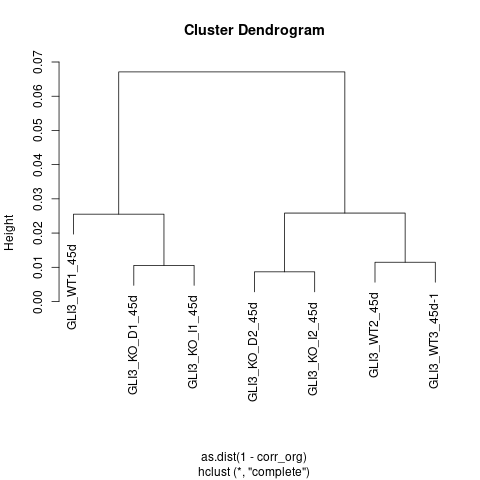

In [51]:
%%R
seurat_ventral <- subset(seurat, subset = seurat_clusters == 0) %>% 
                  FindVariableFeatures()

avg_expr_org <- sapply(sort(unique(seurat$organoid)), function(org) 
                       rowMeans(seurat_ventral@assays$RNA$data[,which(seurat_ventral$organoid == org)]))

corr_org <- cor(avg_expr_org[VariableFeatures(seurat_ventral),]) 
plot(hclust(as.dist(1-corr_org)))


In [55]:
%%R
library(presto)
DE_wilcoxauc_ventral <- wilcoxauc(seurat_ventral, group_by = "GLI3_status") %>% 
    filter(group == "KO") %>%
    mutate(DE = abs(logFC)>log(1.1) & padj < 0.01) %>%
    mutate(DEG = ifelse(abs(logFC)>log(1.1) & padj < 0.01, feature, NA))


Loading required package: Rcpp
Loading required package: data.table
data.table 1.15.2 using 1 threads (see ?getDTthreads).  Latest news: r-datatable.com

Attaching package: 'data.table'

The following objects are masked from 'package:dplyr':

    between, first, last

The following object is masked from 'package:purrr':

    transpose

The following object is masked from 'package:SummarizedExperiment':

    shift

The following object is masked from 'package:GenomicRanges':

    shift

The following object is masked from 'package:IRanges':

    shift

The following objects are masked from 'package:S4Vectors':

    first, second



In [56]:
%%R
install.packages('ggrepel')

During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_TIME failed, using "C" 
3: Setting LC_MESSAGES failed, using "C" 
4: Setting LC_MONETARY failed, using "C" 
5: Setting LC_PAPER failed, using "C" 
6: Setting LC_MEASUREMENT failed, using "C" 
* installing *source* package 'ggrepel' ...
** package 'ggrepel' successfully unpacked and MD5 sums checked
** using staged installation
** libs


/cluster/spack/apps/linux-centos7-x86_64/gcc-4.8.5/gcc-8.2.0-6xqov2fhvbmehix42slain67vprec3fs/bin/g++ -std=gnu++14 -I"/cluster/spack/apps/linux-centos7-x86_64/gcc-8.2.0/r-4.2.2-ydfaklhfrhw5dy6qcfzxlxfviwovcord/rlib/R/include" -DNDEBUG  -I'/cluster/home/tcotet/R/x86_64-pc-linux-gnu-library/4.2/Rcpp/include' -O2 -march=core-avx2 -fPIC -ftree-vectorize -mavx2   -fpic  -O2 -march=core-avx2 -fPIC -ftree-vectorize -mavx2  -c RcppExports.cpp -o RcppExports.o
/cluster/spack/apps/linux-centos7-x86_64/gcc-4.8.5/gcc-8.2.0-6xqov2fhvbmehix42slain67vprec3fs/bin/g++ -std=gnu++14 -I"/cluster/spack/apps/linux-centos7-x86_64/gcc-8.2.0/r-4.2.2-ydfaklhfrhw5dy6qcfzxlxfviwovcord/rlib/R/include" -DNDEBUG  -I'/cluster/home/tcotet/R/x86_64-pc-linux-gnu-library/4.2/Rcpp/include' -O2 -march=core-avx2 -fPIC -ftree-vectorize -mavx2   -fpic  -O2 -march=core-avx2 -fPIC -ftree-vectorize -mavx2  -c repel_boxes.cpp -o repel_boxes.o
/cluster/spack/apps/linux-centos7-x86_64/gcc-4.8.5/gcc-8.2.0-6xqov2fhvbmehix42slain67vpr

installing to /cluster/home/tcotet/R/x86_64-pc-linux-gnu-library/4.2/00LOCK-ggrepel/00new/ggrepel/libs
** R
** inst
** byte-compile and prepare package for lazy loading


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_TIME failed, using "C" 
3: Setting LC_MESSAGES failed, using "C" 
4: Setting LC_MONETARY failed, using "C" 
5: Setting LC_PAPER failed, using "C" 
6: Setting LC_MEASUREMENT failed, using "C" 


** help
*** installing help indices
*** copying figures
** building package indices


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_TIME failed, using "C" 
3: Setting LC_MESSAGES failed, using "C" 
4: Setting LC_MONETARY failed, using "C" 
5: Setting LC_PAPER failed, using "C" 
6: Setting LC_MEASUREMENT failed, using "C" 


** installing vignettes
** testing if installed package can be loaded from temporary location


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_TIME failed, using "C" 
3: Setting LC_MESSAGES failed, using "C" 
4: Setting LC_MONETARY failed, using "C" 
5: Setting LC_PAPER failed, using "C" 
6: Setting LC_MEASUREMENT failed, using "C" 


** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_TIME failed, using "C" 
3: Setting LC_MESSAGES failed, using "C" 
4: Setting LC_MONETARY failed, using "C" 
5: Setting LC_PAPER failed, using "C" 
6: Setting LC_MEASUREMENT failed, using "C" 


** testing if installed package keeps a record of temporary installation path
* DONE (ggrepel)


Installing package into '/cluster/home/tcotet/R/x86_64-pc-linux-gnu-library/4.2'
(as 'lib' is unspecified)
trying URL 'https://cloud.r-project.org/src/contrib/ggrepel_0.9.5.tar.gz'
Content type 'application/x-gzip' length 151033 bytes (147 KB)
downloaded 147 KB


The downloaded source packages are in
	'/scratch/tmp.56906491.tcotet/RtmpboRQ8e/downloaded_packages'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 75508 rows containing missing values (`geom_text_repel()`). 

R[write to console]: 2: ggrepel: 423 unlabeled data points (too many overlaps). Consider increasing max.overlaps 



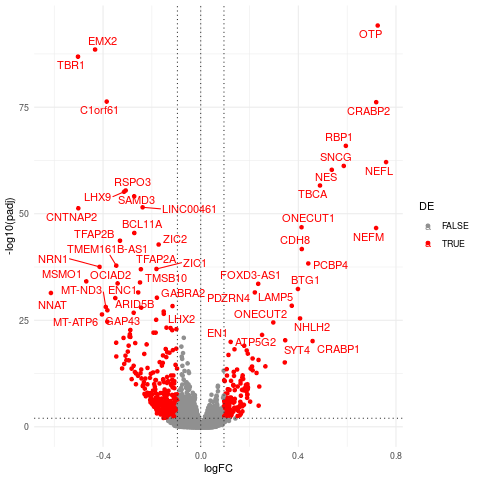

In [62]:
%%R
library(ggplot2) 
ggplot(DE_wilcoxauc_ventral, aes(x = logFC, y = -log10(padj), col=DE, label=DEG)) +
    geom_point() + 
    ggrepel::geom_text_repel() +
    geom_vline(xintercept=c(-log(1.1), log(1.1), 0), col="#303030", linetype="dotted") +
    geom_hline(yintercept=-log10(0.01), col="#303030", linetype="dotted") + scale_color_manual(values=c("#909090", "red")) +
    theme_minimal()


## **DESeq2 differential expression analysis**

In [ ]:
%%R

library(DESeq2) 
library(scran)

det_rate <- rowMeans(seurat_ventral@assays$RNA@data)
meta <- seurat_ventral@meta.data %>% mutate(GLI3_status = factor(GLI3_status, levels=c("WT","KO"))) 
dds <- DESeqDataSetFromMatrix(seurat_ventral@assays$RNA@counts[det_rate > 0.05,],
                                colData=meta,
                                design = ~ GLI3_status)

sizeFactors(dds) <- calculateSumFactors(seurat_ventral@assays$RNA@counts[det_rate > 0.05,]) 
dds <- DESeq(dds, test="LRT", reduced=~1, useT=TRUE, minmu=1e-6, minReplicatesForReplace=Inf) 

DE_deseq2_ventral <- results(dds) %>% as.data.frame() %>%
tibble::rownames_to_column("gene") %>%
    mutate(DE = abs(log2FoldChange)>log2(1.1) & padj < 0.01) %>%
    mutate(DEG = ifelse(abs(log2FoldChange)>log2(1.1) & padj < 0.01, gene, NA))

ggplot(DE_deseq2_ventral, aes(x = log2FoldChange, y = -log10(padj), col=DE, label=DEG)) + 
    geom_point() +
    geom_text_repel(max.overlaps = 20) +
    geom_vline(xintercept=c(-log2(1.1), log2(1.1), 0), col="#303030", linetype="dotted") + 
    geom_hline(yintercept=-log10(0.01), col="#303030", linetype="dotted") + scale_color_manual(values=c("#909090", "red")) +
    theme_minimal()


In [ ]:
aov_DE <- function(expr, cond, covar = NULL, family = "gaussian", test = NULL){ 
    if (is.null(covar)) covar <- data.frame(X_const = 1)
    dat <- data.frame(y = expr,
                      cond = cond,
                covar)
    
    m <- glm(y ~ ., family = family, data = dat)
    m0 <- glm(y ~ . - cond, family = family, data = dat)

    if (is.null(test)){ 
        test <- "F"
        if (ifelse(is(family, "family"), family$family, family) %in% c("binomial","poisson")) 
        test <- "Chisq"
    }
    
    aov <- anova(m, m0, test = test)

    res <- c(coef(m)[grep("^cond",names(coef(m)))], aov$Pr[2]) names(res)[length(res)] <- "pval"
    return(res)
}


In [ ]:
%%R

library(pbapply)

DE_aov <- data.frame(t(pbsapply(which(det_rate > 0.05), function(i) 
    aov_DE(expr = seurat_ventral@assays$RNA@data[i,],
           cond = factor(seurat_ventral$GLI3_status, levels=c("WT","KO")),
           covar = data.frame(cov = log10(seurat_ventral$nCount_RNA))))), row.names=NULL) 

DE_aov$padj <- p.adjust(DE_aov$pval, method="BH")

DE_aov <- data.frame(gene = names(which(det_rate > 0.05)), DE_aov) %>% 
    mutate(DE = abs(condKO)>log(1.1) & padj < 0.01) %>%
    mutate(DEG = ifelse(abs(condKO)>log(1.1) & padj < 0.01, gene, NA))

DE_aov_bin <- data.frame(t(pbsapply(which(det_rate > 0.05), function(i) 
    aov_DE(expr = seurat_ventral@assays$RNA@data[i,] > 0,
           cond = factor(seurat_ventral$GLI3_status, levels=c("WT","KO")), 
           covar = data.frame(cov = seurat_ventral$nCount_RNA),
           family = "binomial"))), row.names=NULL) 

DE_aov_bin$padj <- p.adjust(DE_aov_bin$pval, method="BH")

DE_aov_bin <- data.frame(gene = names(which(det_rate > 0.05)), DE_aov_bin) %>% 
    mutate(DE = padj < 0.01) %>%
    mutate(DEG = ifelse(padj < 0.01, gene, NA))


In [ ]:
%%R

p1 <- ggplot(DE_aov, aes(x = condKO, y = -log10(padj), col=DE, label=DEG)) + 
        geom_point() +
        ggrepel::geom_text_repel(max.overlaps = 20) +
        geom_vline(xintercept=c(-log(1.1), log(1.1), 0), col="#303030", linetype="dotted") + 
        geom_hline(yintercept=-log10(0.01), col="#303030", linetype="dotted") + 
        scale_color_manual(values=c("#909090", "red")) +
        theme_minimal()
        
p2 <- ggplot(DE_aov_bin, aes(x = condKO, y = -log10(padj), col=DE, label=DEG)) + 
        geom_point() +
        ggrepel::geom_text_repel(max.overlaps = 20) +
        geom_vline(xintercept=0, col="#303030", linetype="dotted") + 
        geom_hline(yintercept=-log10(0.01), col="#303030", linetype="dotted") + 
        scale_color_manual(values=c("#909090", "red")) +
        theme_minimal()

p1 | p2


## **Gene ontology**


## **GSEA**


## **DAVID**


In [ ]:
%%R -o scanpy_obj
#convert the Seurat object to a SingleCellExperiment object
scanpy_obj <- as.SingleCellExperiment(seurat)

scanpy_obj